# Roll damping nonlinearity
This notebook is exploring the nonlinerity of roll damping

In [14]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

import data
import copy
from mdldb.mdl_db import MDLDataBase
from mdldb.tables import Base, Model, LoadingCondition, Run, RolldecayLinear, RolldecayDirect, RolldecayNorwegian, RolldecayDirectImproved
from mdldb import mdl_to_evaluation
from evaluation.run_dynamic import RunDynamic
from evaluation.run_manoeuvring import RunZigZag

from rolldecayestimators.direct_estimator import DirectEstimator
from rolldecayestimators.direct_estimator_improved import DirectEstimatorImproved
from rolldecayestimators.direct_linear_estimator import DirectLinearEstimator
from rolldecayestimators.norwegian_estimator import NorwegianEstimator
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
#from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from sklearn.pipeline import Pipeline
from rolldecay.system_identification import load, fit_predict, plot_pipeline
import copy


In [3]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///' + data.mdl_db_path)
db = MDLDataBase(engine=engine)

In [4]:
roll_decay_tests = db.session.query(Run).filter(Run.test_type=='roll decay')

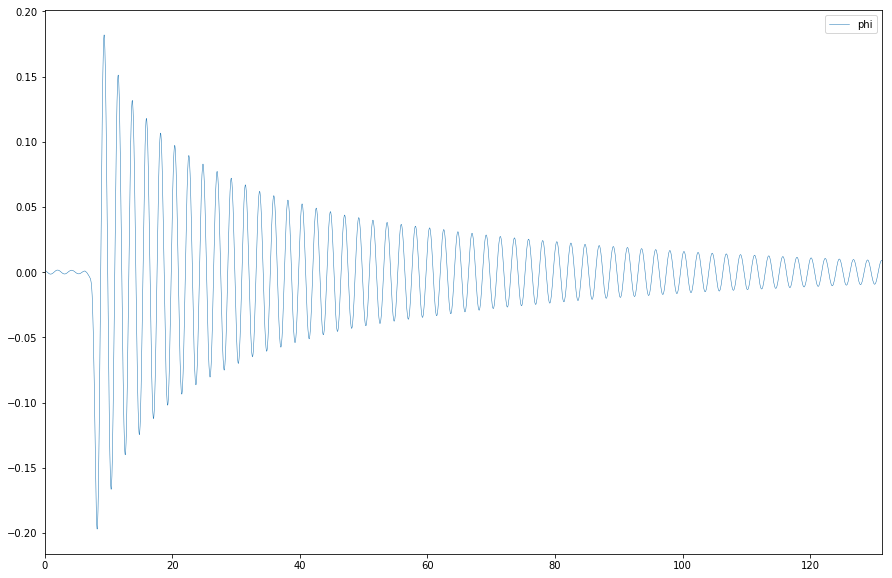

In [5]:
#db_run = roll_decay_tests[0]  # Interesting run... natural frequency changes...
db_run = roll_decay_tests[70]
scale_factor = db_run.model.scale_factor

df = load(db_run)
df.plot(y='phi')


In [6]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=1, minimum_score=0.99)
scaler = ScaleFactorTransformer(scale_factor=None)  # dummy value None for now
cutter = CutTransformer(phi_max=np.deg2rad(15), phi_min=np.deg2rad(0.2))
offset_transformer = OffsetTransformer()
bounds = {
    'omega0':(0,np.inf) # Only positive natural frequency
}

## Linear method

In [7]:
direct_linear_estimator = DirectLinearEstimator(bounds=bounds)

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    #('offset_transformer',offset_transformer),
    ('linear_estimator', direct_linear_estimator)]
        
pipeline_direct_linear = Pipeline(steps) # define the pipeline object.

In [8]:
s, _pipline = fit_predict(df, pipeline=pipeline_direct_linear, scale_factor=scale_factor)
s

{'d': 0,
 'mean_damping': 0.01624261768809044,
 'omega0': 0.39949771098093423,
 'score': 0.9424894696054393,
 'zeta': 0.01624261768809044}

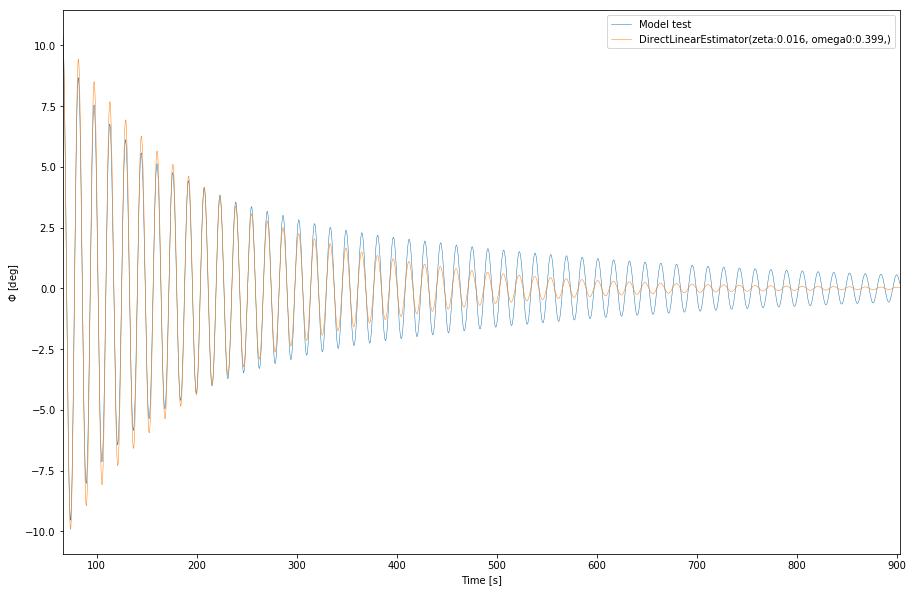

In [9]:
_pipline[-1].plot_fit()

## Quadratic direct

In [10]:
direct_estimator = DirectEstimator(bounds=bounds)

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    #('offset_transformer',offset_transformer),
    ('direct_estimator', direct_estimator)]
        
pipeline_direct = Pipeline(steps) # define the pipeline object.

In [11]:
pipeline_direct

Pipeline(memory=None,
         steps=[('filter',
                 LowpassFilterDerivatorTransformer(cutoff=1, minimum_score=0.99,
                                                   order=5)),
                ('scaler', ScaleFactorTransformer(scale_factor=None)),
                ('cutter',
                 CutTransformer(phi_max=0.2617993877991494,
                                phi_min=0.003490658503988659)),
                ('direct_estimator',
                 DirectEstimator(bounds=[(-inf, -inf), (inf, inf)], ftol=1e-10, maxfev=4000))],
         verbose=False)

In [12]:
cut_index = 0
for key in pipeline_direct.steps:
    if key[0]=='cutter':
        break
    else:
        cut_index+=1
cut_index

2

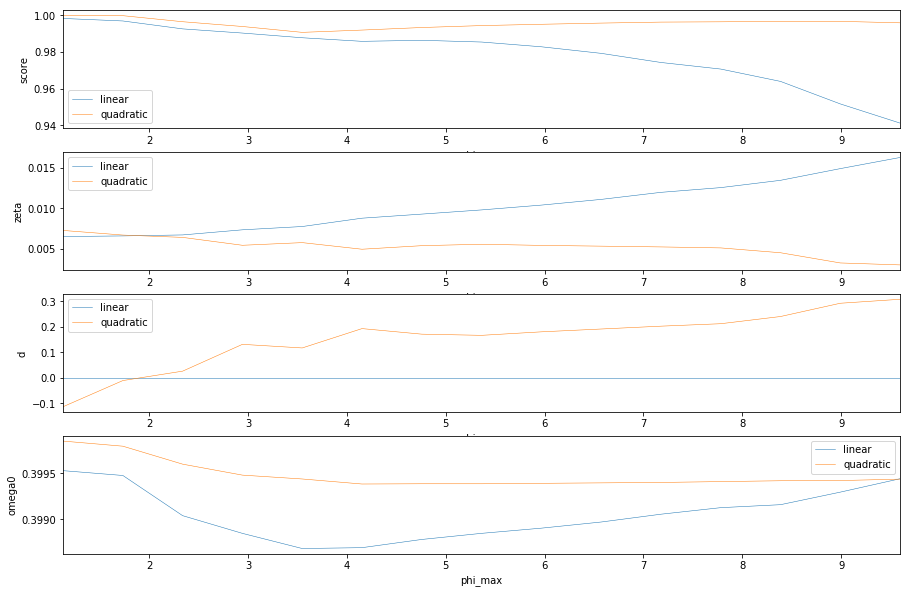

In [13]:
N = 15
phi_maxs = np.linspace(0.85*df['phi'].abs().max(),0.1*df['phi'].abs().max(),N)

results = {
    'linear' : pd.DataFrame(),
    'quadratic' : pd.DataFrame(),
}

pipelines = {
    'linear' : pipeline_direct_linear,
    'quadratic' : pipeline_direct,
}



for phi_max in phi_maxs:
                
    for method, pipeline in pipelines.items():
        
        # Replace the cutter
        _pipline = copy.deepcopy(pipeline)        
        _pipline.steps.pop(cut_index)
        _pipline.steps.insert(cut_index,('cutter',CutTransformer(phi_max=phi_max)))
        
        cutter.phi_max = phi_max
        
        s, _pipline, = fit_predict(df, pipeline=_pipline, scale_factor=scale_factor)
        
        s['phi_max'] = np.rad2deg(phi_max)
        results[method] = results[method].append(s, ignore_index=True)
        

ys = ['score', 'zeta', 'd', 'omega0']
fig,axes = plt.subplots(nrows=len(ys))
for method, result in results.items():

    for y,ax in zip(ys,axes):
        
        result.plot(x='phi_max', y=y, ax=ax, label=method)
        ax.set_ylabel(y)
    
    